In [1]:
%load_ext autoreload
%autoreload 2

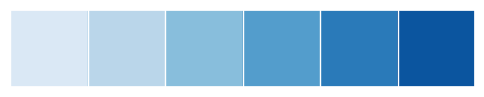

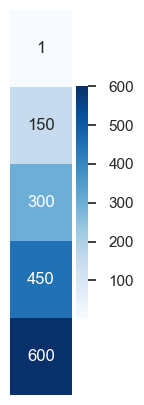

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

plt.style.use(style="seaborn-v0_8-talk")
sns.set_theme(style="darkgrid")

PALETTE = "Blues"
sns.palplot(sns.color_palette(PALETTE))
matrix = np.linspace(1, 600, 5).reshape(5, 1).astype(int)
fig = plt.figure(figsize=(1, 5))
sns_plot = sns.heatmap(
    matrix,
    annot=True,
    cmap=PALETTE,
    cbar=True,
    fmt=".0f",
    xticklabels=False,
    yticklabels=False,
)
plt.show()

In [3]:
df_charge1 = pd.read_excel('button_battery.xlsx', sheet_name='前charge')
df_charge2 = pd.read_excel('button_battery.xlsx', sheet_name='中charge')
df_eis1 = pd.read_excel('button_battery.xlsx', sheet_name='前EIS')
df_eis2 = pd.read_excel('button_battery.xlsx', sheet_name='中EIS')

In [4]:
df_charge1.keys(), df_charge2.keys(), df_eis1.keys(), df_eis2.keys()

(Index(['Ewe/V', 'I/mA', 'time/s'], dtype='object'),
 Index(['Ewe/V', 'I/mA', 'time/s'], dtype='object'),
 Index(['freq/Hz', 'Re(Z)/Ohm', ' -Im(Z)/Ohm'], dtype='object'),
 Index(['freq/Hz', 'Re(Z)/Ohm', ' -Im(Z)/Ohm'], dtype='object'))

In [5]:
df_charge1.count(), df_charge2.count(), df_eis1.count(), df_eis2.count()

(Ewe/V     133239
 I/mA      133239
 time/s    133239
 dtype: int64,
 Ewe/V     128227
 I/mA      128227
 time/s    128227
 dtype: int64,
 freq/Hz        133239
 Re(Z)/Ohm      133239
  -Im(Z)/Ohm    133239
 dtype: int64,
 freq/Hz        128227
 Re(Z)/Ohm      128227
  -Im(Z)/Ohm    128227
 dtype: int64)

In [6]:
def read_data(df_charge, df_eis):
    EPS = 1e-3
    
    DATA_LIST = []
    
    # eis in EIS_list:
    """
    data = {
        capacity: float,
        charge: {
            voltage: [],
            current: []
        },
        discharge: {
            voltage: [],
            current: []
        },
        eis: {
            freq: [],
            Re: [],
            -Im: []
        }
    }
    """
    
    capacity_list = []
    charge_list = []
    discharge_list = []
    eis_list = []
        
    voltage = []
    current = []
    
    cnt = 0
    
    # charge, discharge, capacity
    for idx, row in df_charge.iterrows():
        v = row['Ewe/V']
        i = row['I/mA']
        
        if abs(i) < EPS:
            if cnt == 3:
                cnt = 0
                if len(current) > 3:
                    _ = sum(current)
                    if _ > 0:
                        charge_list.append({'voltage': voltage, 'current': current})
                    else:
                        discharge_list.append({'voltage': voltage, 'current': current})
                        capacity_list.append(-_ * 10.0 / 3600.0) # mAh            
                voltage = []
                current = []
            else:
                cnt += 1
        else:
            cnt = 0
            if abs(v) > 1e-1 and abs(i) > 1e-1:
                voltage.append(v)
                current.append(i)
                    
    # eis
    freq_list = []
    Re_list = []
    Im_list = []
    for idx, row in df_eis.iterrows():
        freq = row['freq/Hz']
        Re = row['Re(Z)/Ohm']
        Im = row[' -Im(Z)/Ohm']
        
        if freq == 0:
            if len(freq_list) > 0:
                eis_list.append({
                    'freq': freq_list,
                    'Re': Re_list,
                    '-Im': Im_list
                })
            freq_list = []
            Re_list = []
            Im_list = []
        else:
            freq_list.append(freq)
            Re_list.append(Re)
            Im_list.append(-Im)
        
    print(f"capacity_list: {len(capacity_list)}")
    print(f"charge_list: {len(charge_list)}")
    print(f"discharge_list: {len(discharge_list)}")
    print(f"eis_list: {len(eis_list)}")
          
    # assert len(capacity_list) == len(charge_list) == len(discharge_list) == len(eis_list)
    
    min_len = min(len(capacity_list), len(charge_list), len(discharge_list), len(eis_list))
    capacity_list = capacity_list[:min_len]
    charge_list = charge_list[:min_len]
    discharge_list = discharge_list[:min_len]
    eis_list = eis_list[:min_len]
    
    for i in range(len(capacity_list)):
        data = {
            'capacity': capacity_list[i],
            'charge': charge_list[i],
            'discharge': discharge_list[i],
            'eis': eis_list[i]
        }
        DATA_LIST.append(data)
        
    return DATA_LIST

In [7]:
print("第一部分")
DATA_LIST = read_data(df_charge1, df_eis1)
DATA_LIST.pop(0)
# print("第二部分")
# DATA_LIST += read_data(df_charge2, df_eis2)
print(f"DATA_LIST: {len(DATA_LIST)}")

第一部分
capacity_list: 153
charge_list: 153
discharge_list: 153
eis_list: 153
DATA_LIST: 152


容量下降曲线

In [8]:
threshold = 0.83

In [9]:
def get_80_percent_point(capacity):
    cnt = 0
    target_idx = -1
    target_capacity = 0
    for i, c in enumerate(capacity):
        if c < threshold * capacity[0]:
            if cnt == 0:
                target_idx = i
                target_capacity = c
            if cnt == 3:
                return target_idx, target_capacity
            cnt += 1
        else:
            cnt = 0
            
    raise ValueError("No 80% point found")

In [10]:
def plot_capacity(capacity_list):
    plt.figure(figsize=(8, 5))
    plt.plot(capacity_list, label='Capacity')
    plt.scatter(*get_80_percent_point(capacity_list), color='r')
    plt.plot([0, len(capacity_list)], [threshold * capacity_list[0], threshold * capacity_list[0]], color='r', linestyle='--', label='80%')
    plt.xlabel('Cycle', fontsize=18)
    plt.ylabel('Capacity (mAh)', fontsize=16)
    plt.title('Capacity vs Cycle', fontsize=16)
    plt.legend()
    plt.show()

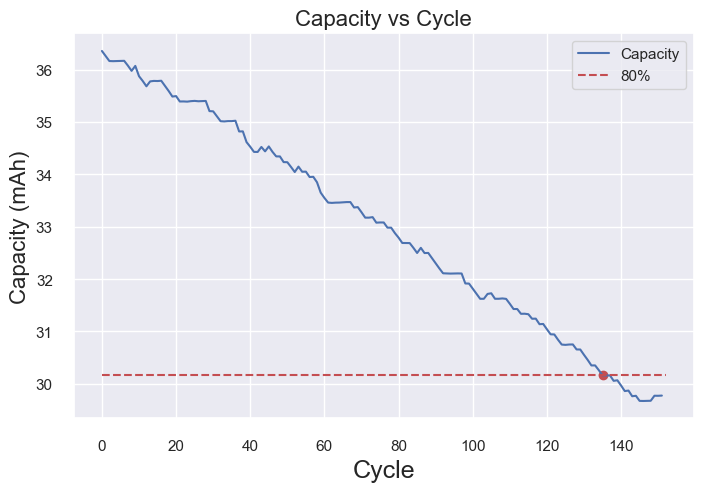

In [14]:
capacity = [data['capacity'] for data in DATA_LIST]
plot_capacity(capacity)

In [15]:
np.save('capacity.npy', np.array(capacity))

充放电曲线

In [41]:
def plot_curve(voltage_series, current_series):
    # 绘制电压和电流曲线
    plt.figure(figsize=(10, 5))

    # 电压曲线
    plt.subplot(1, 2, 1)
    plt.plot([e / 6 for e in range(len(voltage_series))], voltage_series, linestyle="-", color="#14979f", linewidth=4)
    plt.title("Voltage over Time", fontsize=16)
    plt.xlabel("Time (min)", fontsize=14)
    plt.ylabel("Voltage (V)", fontsize=14)

    # 电流曲线
    plt.subplot(1, 2, 2)
    plt.plot([e / 6 for e in range(len(current_series))], current_series, linestyle="-", color="#ed6c00", linewidth=4)
    plt.title("Current over Time", fontsize=16)
    plt.xlabel("Time (min)", fontsize=14)
    plt.ylabel("Current (A)", fontsize=14)

    plt.tight_layout()
    plt.show()

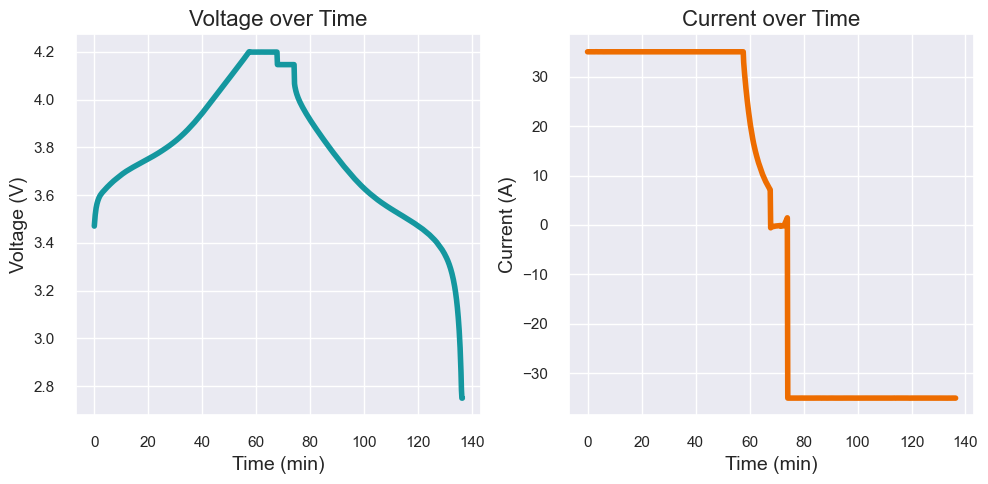

In [55]:
voltage_series = DATA_LIST[0]['charge']['voltage'] + DATA_LIST[0]['discharge']['voltage']
current_series = DATA_LIST[0]['charge']['current'] + DATA_LIST[0]['discharge']['current']

plot_curve(voltage_series, current_series)

407 407


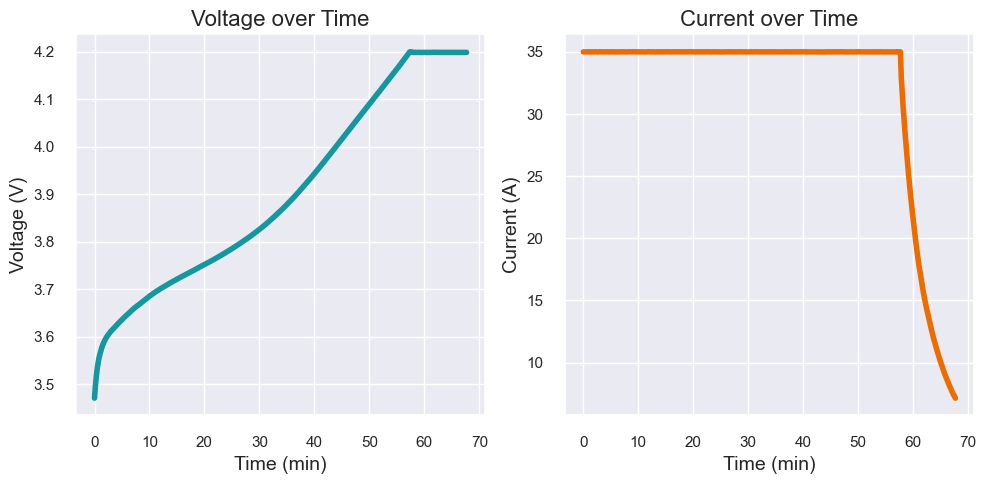

In [75]:
voltage_series = DATA_LIST[0]['charge']['voltage']
current_series = DATA_LIST[0]['charge']['current']

print(len(voltage_series), len(current_series))

plot_curve(voltage_series, current_series)

333 333


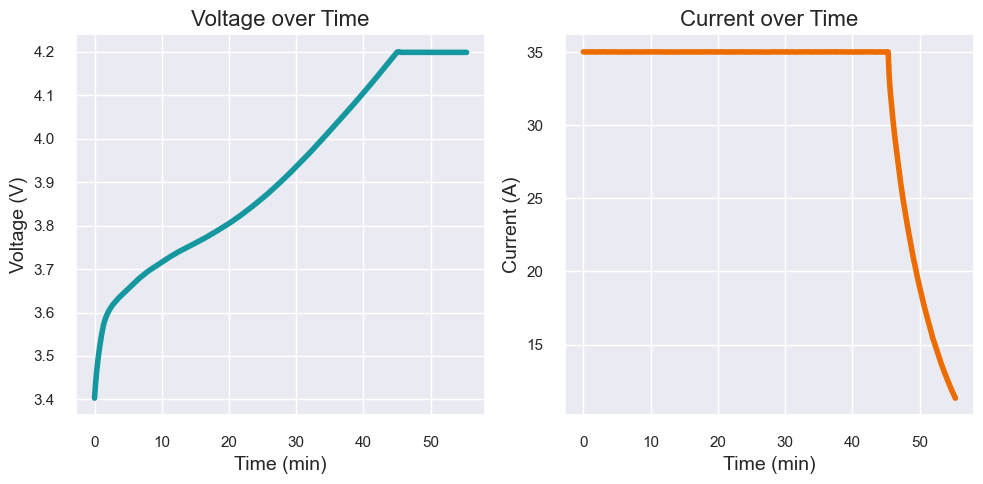

In [76]:
voltage_series = DATA_LIST[-1]['charge']['voltage']
current_series = DATA_LIST[-1]['charge']['current']

print(len(voltage_series), len(current_series))

plot_curve(voltage_series, current_series)

In [67]:
print(len(DATA_LIST))

152


In [29]:
voltages_list = []
currents_list = []

for data in DATA_LIST:
    voltages = [v for v in data['charge']['voltage'] if v < 4.195]
    voltages_list.append(voltages)
    
    currents = [c for c in data['charge']['current'] if c < 34.9]
    currents_list.append(currents)

plot_curve(voltages_list[0], currents_list[0])
plot_curve(voltages_list[100], currents_list[100])
plot_curve(voltages_list[-1], currents_list[-1])

NameError: name 'plot_curve' is not defined

In [ ]:
def get_vCC_iCV(curves, Vl, Il):
    
    def get_closest_idx(arr, target):
        return np.argmin(np.abs(arr - target))
    
    voltage_CC = []
    current_CV = []
    for index, curve in enumerate(curves):
        v_CC = curve['charge']['voltage']
        i_CV = curve['charge']['current']
        idx_vl = get_closest_idx(np.array(v_CC), Vl)
        idx_il = get_closest_idx(np.array(i_CV), Il)
        voltage_CC.append(v_CC[idx_vl:])
        current_CV.append(i_CV[:idx_il])

    print("-" * 50)

    return voltage_CC, current_CV


In [68]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


def plot_main_curves(voltage_CC, current_CV, palette):
    plt.figure(figsize=(12, 6))

    # 绘制电压曲线
    plt.subplot(1, 2, 1)
    colors = sns.color_palette(palette, n_colors=len(voltage_CC))
    for idx, voltage in enumerate(voltage_CC):
        sns.lineplot(
            x=[t / 6 for t in range(len(voltage))],
            y=voltage,
            color=colors[idx],
            linewidth=0.5,
        )
    plt.title("Voltage over Time", fontsize=16)
    plt.xlabel("Time (min)", fontsize=14)
    plt.ylabel("Voltage (V)", fontsize=14)

    # 绘制电流曲线
    plt.subplot(1, 2, 2)
    colors = sns.color_palette(
        palette,
        n_colors=len(current_CV),
    )
    for idx, current in enumerate(current_CV):
        sns.lineplot(
            x=[t / 6 for t in range(len(current))],
            y=current,
            color=colors[idx],
            linewidth=0.5,
            label=(f"Cycle {idx+1}" if idx == 0 or idx == len(current_CV) - 1 else None),
        )

    plt.title("Current over Time", fontsize=16)
    plt.xlabel("Time (min)", fontsize=14)
    plt.ylabel("Current (A)", fontsize=14)

    # 设置图例
    handles, labels = plt.gca().get_legend_handles_labels()
    for handle in handles:
        handle.set_linewidth(2)  # 设置线条的粗细为2
    display_handles = [handles[0], handles[-1]]
    display_labels = [labels[0], labels[-1]]
    plt.legend(display_handles, display_labels, fontsize=12)

    plt.tight_layout()
    plt.show()

152 152


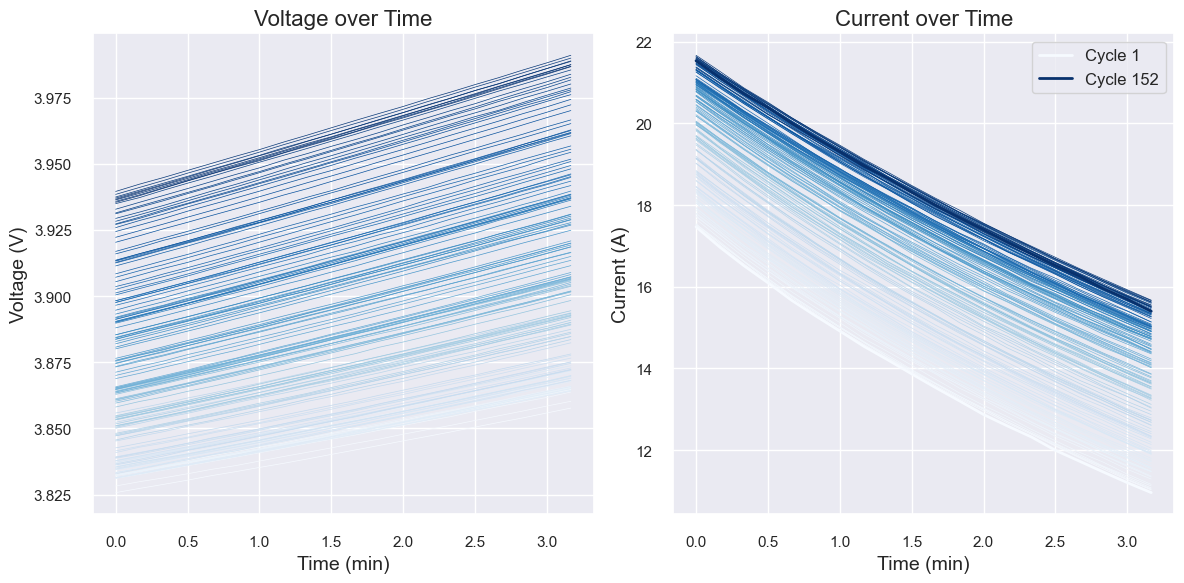

In [69]:
voltages_CC = [voltages[180:200] for voltages in voltages_list]
current_CV = [currents[20:40] for currents in currents_list]
print(len(voltages_CC), len(current_CV))

plot_main_curves(voltages_CC, current_CV, PALETTE)

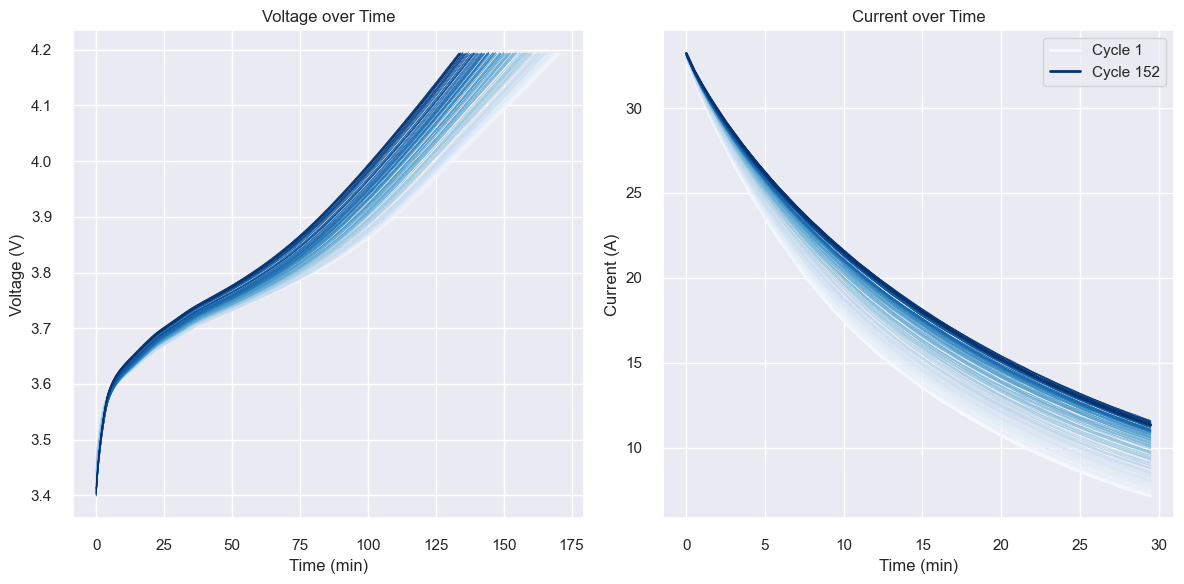

In [81]:
plot_main_curves(voltages_list, currents_list, PALETTE)

EIS曲线

In [9]:
def plot_eis(EIS_list, plot_type='nyquist'):
    palette = sns.color_palette(PALETTE, n_colors=len(EIS_list))
    plt.figure(figsize=(8, 6))  # 稍微增加图的宽度以容纳图例


    if plot_type == 'nyquist':            
        for idx, eis in enumerate(EIS_list):
            plt.plot(eis['Re'], eis['-Im'], color=palette[idx], label=f'{idx}')
        plt.title("EIS Curve (Nyquist)", fontsize=18)
        plt.xlabel("Re(Z)", fontsize=16)
        plt.ylabel("-Im(Z)", fontsize=16)
    
    elif plot_type == 're':
        for idx, eis in enumerate(EIS_list):
            plt.plot(eis['freq'][0:100], eis['Re'][0:100], color=palette[idx], label=f'Cycle {idx}')
        plt.title("EIS Curve (Real)")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Re(Z)")
        
    elif plot_type == 'im':
        for idx, eis in enumerate(EIS_list):
            plt.plot(eis['freq'], eis['-Im'], color=palette[idx], label=f'Cycle {idx}')
        plt.title("EIS Curve (Imaginary)")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("-Im(Z)")
        
    # plt.legend(title="", loc='center left', bbox_to_anchor=(1, 0.5), fontsize=0.1, title_fontsize='large')
    
    # plt.ylim(-0.01, 0.005)
    # plt.subplots_adjust(right=0.75)
    plt.show()
    

In [10]:
EIS = [data['eis'] for data in DATA_LIST]

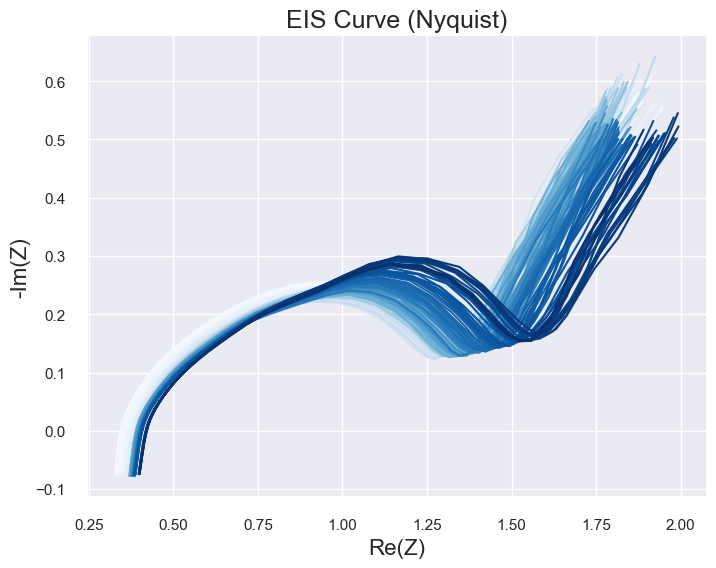

In [25]:
plot_eis(EIS)

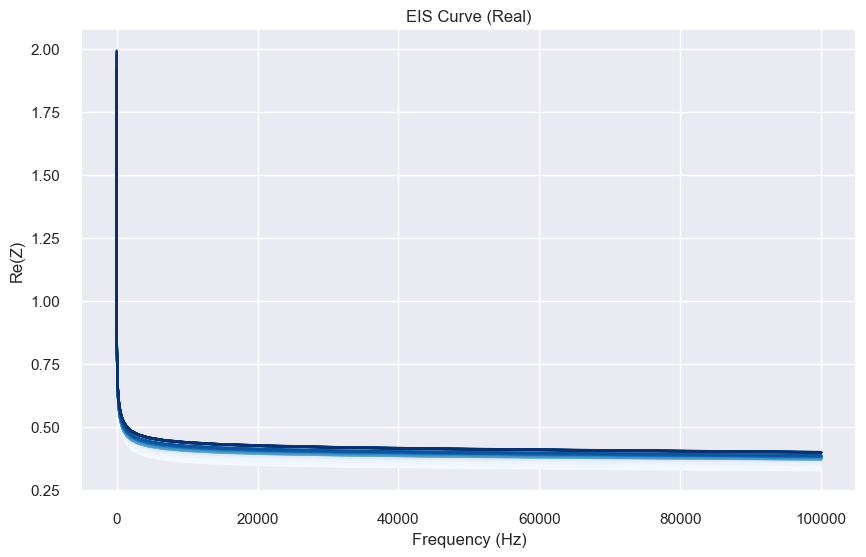

In [161]:
plot_eis(EIS, plot_type='re')

14539.417 452.46143


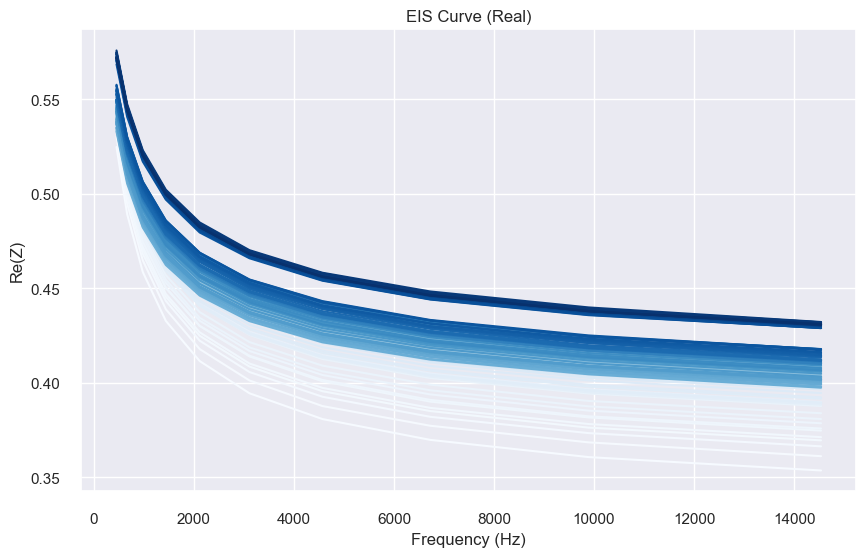

In [40]:
start = 5
end = 15

palette = sns.color_palette(PALETTE, n_colors=len(EIS))
plt.figure(figsize=(10, 6))
for idx, eis in enumerate(EIS):
    plt.plot(eis['freq'][start:end], eis['Re'][start:end], color=palette[idx])
plt.title("EIS Curve (Real)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Re(Z)")

print(eis['freq'][start], eis['freq'][end-1])
plt.show()

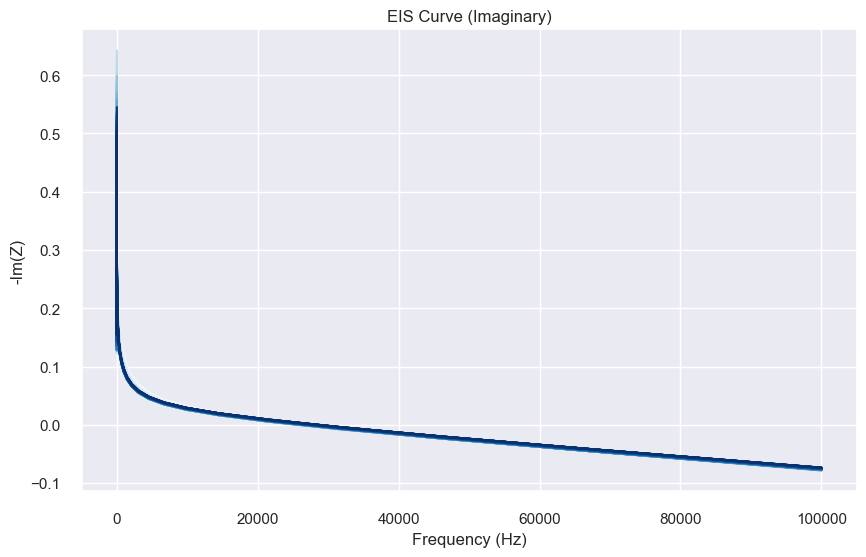

In [162]:
plot_eis(EIS, plot_type='im')

2115.6768 65.778824


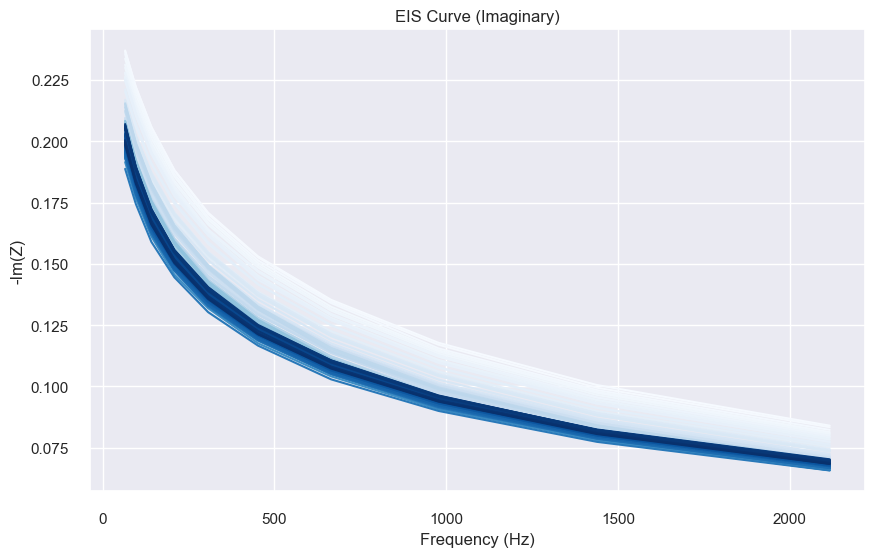

In [33]:
start = 10
end = 20

palette = sns.color_palette(PALETTE, n_colors=len(EIS))
plt.figure(figsize=(10, 6))
for idx, eis in enumerate(EIS):
    plt.plot(eis['freq'][start:end], eis['-Im'][start:end], color=palette[idx])
plt.title("EIS Curve (Imaginary)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("-Im(Z)")

print(eis['freq'][start], eis['freq'][end-1])
plt.show()

14539.417 452.46143
2115.6768 65.778824


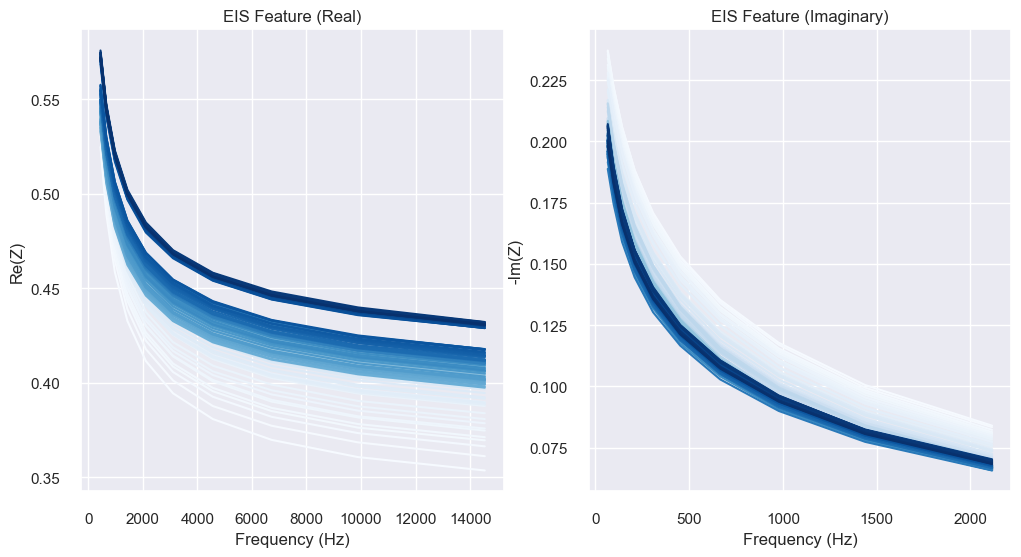

In [72]:
start_re = 5
end_re = 15

start_im = 10
end_im = 20

print(eis['freq'][start_re], eis['freq'][end_re-1])
print(eis['freq'][start_im], eis['freq'][end_im-1])

palette = sns.color_palette(PALETTE, n_colors=len(EIS))
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
for idx, eis in enumerate(EIS):
    plt.plot(eis['freq'][start_re:end_re], eis['Re'][start_re:end_re], color=palette[idx])
plt.title("EIS Feature (Real)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Re(Z)")


plt.subplot(1, 2, 2)
for idx, eis in enumerate(EIS):
    plt.plot(eis['freq'][start_im:end_im], eis['-Im'][start_im:end_im], color=palette[idx])
plt.title("EIS Feature (Imaginary)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("-Im(Z)")

plt.show()

将eis保存为numpy数组，并储存为feature文件

In [64]:
import numpy as np

features = []

voltages_CC = [voltages[180:200] for voltages in voltages_list]
for voltages in voltages_CC:
    features.append(voltages)
    
currents_CV = [currents[20:40] for currents in currents_list]
for idx, currents in enumerate(currents_CV):
    features[idx] += currents
    
for idx, eis in  enumerate(EIS):
    features[idx] += list(eis['Re'][5:15]) + list(eis['-Im'][10:20])

features = np.array(features)

print(features.shape)

(152, 60)


In [65]:
np.save('features.npy', features)

提取EIS特征

In [15]:
EIS[0].keys()

dict_keys(['freq', 'Re', '-Im'])

In [23]:
import pickle

with open('EIS.pickle', 'wb') as f:
    pickle.dump(EIS, f)

In [16]:
def get_tangent_idx(x_list, y_list):
    tangent = [
        (y_list[i+1] - 0) / (x_list[i+1] - 0)
        for i in range(len(x_list) - 1)
    ]
    return np.argmax(np.array(tangent))

In [17]:
idx = 60

Peek 	idx: 24	freq: 9.5624247	Re: 1.0679353	-Im: 0.24882823
Valley 	idx: 32	freq: 0.43767506	Re: 1.4078374	-Im: 0.1479847
Ohmage 	idx: 4	freq: 21386.949	Re: 0.40081447	-Im: 0.0061958726
Freq1 	idx: 36	freq: 0.093500197	Re: 1.5465071	-Im: 0.25580841
Tan 	idx: 18	freq: 96.765022	Re: 0.70218259	-Im: 0.19245261


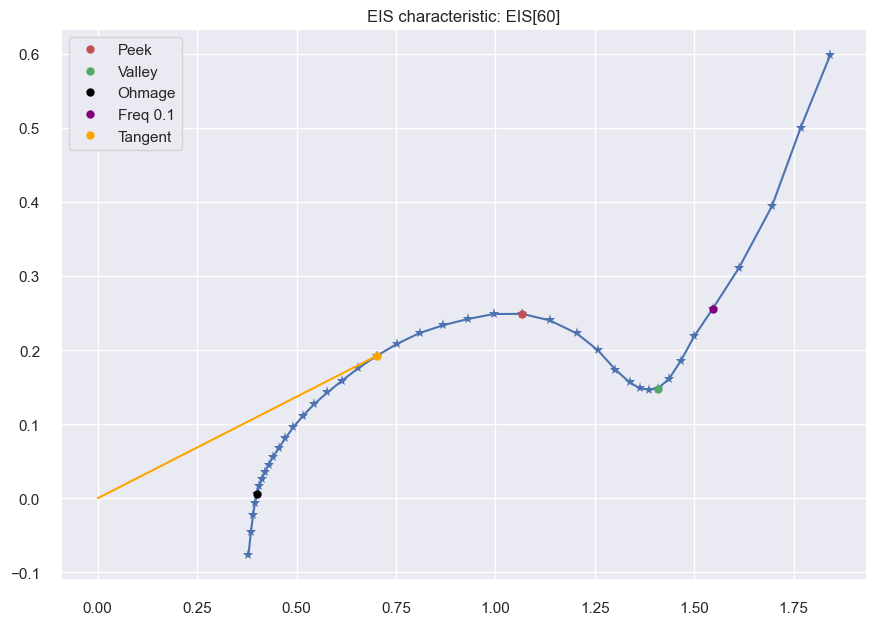

In [24]:
from scipy.signal import find_peaks, find_peaks_cwt

EIS[idx]["-Im"]

plt.plot(EIS[idx]["Re"], EIS[idx]["-Im"], "*-", markersize=8)

# peaks = find_peaks_cwt(EIS[idx]["-Im"], 5)
# print(peaks)

peek = 24
print(
    f"Peek \tidx: {peek}\tfreq: {EIS[idx]['freq'][peek]}\tRe: {EIS[idx]['Re'][peek]}\t-Im: {EIS[idx]['-Im'][peek]}"
)
plt.plot(
    EIS[idx]["Re"][peek],
    EIS[idx]["-Im"][peek],
    "ro",
    label="Peek",
)

valley = 32
print(
    f"Valley \tidx: {valley}\tfreq: {EIS[idx]['freq'][valley]}\tRe: {EIS[idx]['Re'][valley]}\t-Im: {EIS[idx]['-Im'][valley]}"
)
plt.plot(
    EIS[idx]["Re"][valley],
    EIS[idx]["-Im"][valley],
    "go",
    label="Valley",
)

zero_point_idx = np.argmin(np.abs(np.array(EIS[idx]["-Im"]) - 0))
print(
    f"Ohmage \tidx: {zero_point_idx}\tfreq: {EIS[idx]['freq'][zero_point_idx]}\tRe: {EIS[idx]['Re'][zero_point_idx]}\t-Im: {EIS[idx]['-Im'][zero_point_idx]}"
)
plt.plot(
    EIS[idx]["Re"][zero_point_idx],
    EIS[idx]["-Im"][zero_point_idx],
    "o",
    color="black",
    label="Ohmage",
)

freq_dot1_idx = np.argmin(np.abs(np.array(EIS[idx]["freq"]) - 0.1))
print(
    f"Freq1 \tidx: {freq_dot1_idx}\tfreq: {EIS[idx]['freq'][freq_dot1_idx]}\tRe: {EIS[idx]['Re'][freq_dot1_idx]}\t-Im: {EIS[idx]['-Im'][freq_dot1_idx]}"
)
plt.plot(
    EIS[idx]["Re"][freq_dot1_idx],
    EIS[idx]["-Im"][freq_dot1_idx],
    "o",
    color="purple",
    label="Freq 0.1",
)

tangent_idx = get_tangent_idx(EIS[idx]["Re"][:valley], EIS[idx]["-Im"][:valley])
print(
    f"Tan \tidx: {tangent_idx}\tfreq: {EIS[idx]['freq'][tangent_idx]}\tRe: {EIS[idx]['Re'][tangent_idx]}\t-Im: {EIS[idx]['-Im'][tangent_idx]}"
)
plt.plot(
    EIS[idx]["Re"][tangent_idx],
    EIS[idx]["-Im"][tangent_idx],
    "o",
    color="orange",
    label="Tangent",
)
plt.plot(
    [0, EIS[idx]["Re"][tangent_idx]],
    [0, EIS[idx]["-Im"][tangent_idx]],
    color="orange",
)

plt.legend()

plt.title(f"EIS characteristic: EIS[{idx}]")
plt.show()

In [25]:
features_eis = []
for idx in range(len(EIS)):
    eis = EIS[idx]
    feature = []
    
    peek = 24
    feature.append(eis['Re'][peek])
    feature.append(eis['-Im'][peek])
    feature.append(np.sqrt(eis["Re"][peek] ** 2 + eis["-Im"][peek] ** 2))
    
    valley = 32
    feature.append(eis['Re'][valley])
    feature.append(eis['-Im'][valley])
    feature.append(np.sqrt(eis["Re"][valley] ** 2 + eis["-Im"][valley] ** 2))
    
    zero_point_idx = np.argmin(np.abs(np.array(eis["-Im"]) - 0))
    feature.append(eis['Re'][zero_point_idx])
    feature.append(eis['-Im'][zero_point_idx])
    feature.append(np.sqrt(eis["Re"][zero_point_idx] ** 2 + eis["-Im"][zero_point_idx] ** 2))
    
    freq_dot1_idx = np.argmin(np.abs(np.array(eis["freq"]) - 0.1))
    feature.append(eis['Re'][freq_dot1_idx])
    feature.append(eis['-Im'][freq_dot1_idx])
    feature.append(np.sqrt(eis["Re"][freq_dot1_idx] ** 2 + eis["-Im"][freq_dot1_idx] ** 2))
    
    tangent_idx = get_tangent_idx(eis["Re"][:valley], eis["-Im"][:valley])
    feature.append(eis['Re'][tangent_idx])
    feature.append(eis['-Im'][tangent_idx])
    feature.append(np.sqrt(eis["Re"][tangent_idx] ** 2 + eis["-Im"][tangent_idx] ** 2))
    
    features_eis.append(feature)
    
features_eis = np.array(features_eis)

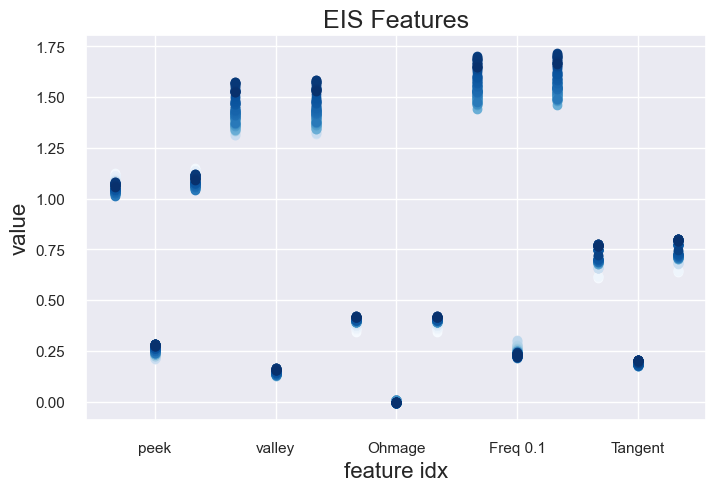

In [26]:
palette = sns.color_palette(PALETTE, n_colors=len(features_eis))
plt.figure(figsize=(8, 5))  # 稍微增加图的宽度以容纳图例

for idx, feature in enumerate(features_eis):
    plt.scatter(range(len(feature)), feature, color=palette[idx])
plt.title("EIS Features", fontsize=18)
plt.xlabel("feature idx", fontsize=16)
plt.ylabel("value", fontsize=16)

plt.xticks([1, 4, 7, 10, 13], ['peek', 'valley', 'Ohmage', 'Freq 0.1', 'Tangent'])

plt.show()

In [32]:
import numpy as np

features = []

voltages_CC = [voltages[180:200] for voltages in voltages_list]
for voltages in voltages_CC:
    features.append(voltages)

currents_CV = [currents[20:40] for currents in currents_list]
for idx, currents in enumerate(currents_CV):
    features[idx] += currents

for idx, eis in enumerate(features_eis):
    features[idx] += list(eis)

features = np.array(features)

print(features.shape)

(152, 55)


In [33]:
np.save("features_eis.npy", features)